# Fertility Analysis Methods

This notebook performs life table analysis and Kaplan-Meier survival analysis on a fertility dataset to:

1. Estimate the probability of pregnancy within 13 cycles.
2. Compute the median time to pregnancy.
3. Identify significant predictors using Cox proportional hazards regression.

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))

from src.data_cleaning import load_data, drop_index_column

# Set plot style
sns.set(style='whitegrid')


## Load the Dataset

In [ ]:
df = load_data('../data/raw/ncdatachallenge-2021-v1.csv')
df = drop_index_column(df)
df.head()

INFO: 'Unnamed: 0' column dropped.


,bmi,age,country,been_pregnant_before,education,sleeping_pattern,n_cycles_trying,outcome,dedication,average_cycle_length,cycle_length_std,regular_cycle,intercourse_frequency
0,22.942130,31,SE,"No, never",University,Wake same every workday,1,pregnant,0.640000,25.588235,2.526332,True,0.200000
1,19.886054,34,NaN,NaN,University,NaN,7,pregnant,0.009569,30.875000,3.522884,True,0.052632
2,29.323049,41,SE,"No, never",University,Several times during the night,4,not_pregnant,0.298246,27.666667,2.503331,True,0.149123
3,24.386526,27,SE,"No, never",High school,Wake same every workday,2,pregnant,0.895833,24.250000,3.453776,True,0.145833
4,29.299971,29,SE,"No, never",Trade/technical/vocational training,Wake same every day,2,pregnant,0.666667,25.466667,0.990430,True,0.254902


## Data Overview

In [6]:
# Summary statistics
df.describe(include='all')

,bmi,age,country,been_pregnant_before,education,sleeping_pattern,n_cycles_trying,outcome,dedication,average_cycle_length,cycle_length_std,regular_cycle,intercourse_frequency
count,1995.000000,1995.000000,1882,1678,1604,1496,1995.000000,1995,1995.000000,1989.000000,1970.000000,1989,1995.000000
unique,NaN,NaN,34,4,5,5,NaN,2,NaN,NaN,NaN,2,NaN
top,NaN,NaN,SE,"No, never",University,Wake same every workday,NaN,pregnant,NaN,NaN,NaN,True,NaN
freq,NaN,NaN,612,1202,1089,808,NaN,1148,NaN,NaN,NaN,1569,NaN
mean,23.357643,31.898747,NaN,NaN,NaN,NaN,4.725815,NaN,0.475641,30.530185,4.465253,NaN,0.106986
std,4.982275,4.063534,NaN,NaN,NaN,NaN,4.600871,NaN,0.335528,7.010407,8.675280,NaN,0.105248
min,0.000000,19.000000,NaN,NaN,NaN,NaN,1.000000,NaN,0.000000,19.500000,0.000000,NaN,0.000000
25%,20.708276,29.000000,NaN,NaN,NaN,NaN,1.000000,NaN,0.132567,27.176471,1.718249,NaN,0.020000
50%,22.530864,32.000000,NaN,NaN,NaN,NaN,3.000000,NaN,0.505415,29.000000,2.542727,NaN,0.080214
75%,25.303154,35.000000,NaN,NaN,NaN,NaN,6.000000,NaN,0.780816,31.666667,4.272002,NaN,0.162195


## 1- Estimate the cumulative probability of pregnancy within 13 cycles.

### Fraction of people who got pregnant within 13 cycles

In [7]:
df = df.dropna(subset=['n_cycles_trying', 'outcome'])
df.describe(percentiles=[0.05, 0.25, 0.75])

,bmi,age,n_cycles_trying,dedication,average_cycle_length,cycle_length_std,intercourse_frequency
count,1995.000000,1995.000000,1995.000000,1995.000000,1989.000000,1970.000000,1995.000000
mean,23.357643,31.898747,4.725815,0.475641,30.530185,4.465253,0.106986
std,4.982275,4.063534,4.600871,0.335528,7.010407,8.675280,0.105248
min,0.000000,19.000000,1.000000,0.000000,19.500000,0.000000,0.000000
5%,18.519846,25.000000,1.000000,0.000000,25.125000,1.000000,0.000000
25%,20.708276,29.000000,1.000000,0.132567,27.176471,1.718249,0.020000
50%,22.530864,32.000000,3.000000,0.505415,29.000000,2.542727,0.080214
75%,25.303154,35.000000,6.000000,0.780816,31.666667,4.272002,0.162195
max,50.611299,44.000000,26.000000,1.347826,145.500000,168.998521,0.793103


In [8]:
# Only keep relevant columns
cols = ['n_cycles_trying', 'outcome']
df_filtered = df[cols]

max_cycle = 13

results = []
remaining = len(df_filtered)
for cycle in range(1, max_cycle + 1):
    # Pregnant this cycle
    preg = df_filtered[(df_filtered['outcome'] == 'pregnant') & (df_filtered['n_cycles_trying'] == cycle)]
    # Dropouts (stopped trying, but not pregnant)
    dropouts = df_filtered[(df_filtered['outcome'] == 'not_pregnant') & (df_filtered['n_cycles_trying'] == cycle)]
    
    n_preg = len(preg)
    n_drop = len(dropouts)
    
    if remaining > 0:
        success_rate = n_preg / remaining
    else:
        success_rate = 0
    
    results.append({
        'n_cycle': cycle,
        'Remaining': remaining,
        'Pregnant': n_preg,
        'Dropouts': n_drop,
        'Success Rate': round(success_rate, 3)
    })
    
    # Subtract those who got pregnant or dropped out at this cycle from remaining
    remaining -= (n_preg + n_drop)

# Convert to DataFrame for display
preg_table = pd.DataFrame(results)
preg_table


,n_cycle,Remaining,Pregnant,Dropouts,Success Rate
0,1,1995,350,170,0.175
1,2,1475,229,115,0.155
2,3,1131,178,88,0.157
3,4,865,104,68,0.120
4,5,693,74,40,0.107
5,6,579,56,50,0.097
6,7,473,50,28,0.106
7,8,395,27,33,0.068
8,9,335,25,24,0.075
9,10,286,16,25,0.056


In [9]:
# Calculate the failure rate and total failure rate
preg_table["Failure Rate"] = 1 - preg_table["Success Rate"]
failure_rate_product = preg_table["Failure Rate"].prod()
# Calculate the success rate
result = (1- failure_rate_product)
result

np.float64(0.7491120751381394)

### Kaplan-Meier Estimate
The KM estimate includes both pregnant and censored users, and asks:

“What is the chance that a user gets pregnant within 13 cycles?”
Based on survival logic: adjusts for users who didn’t get pregnant (yet)

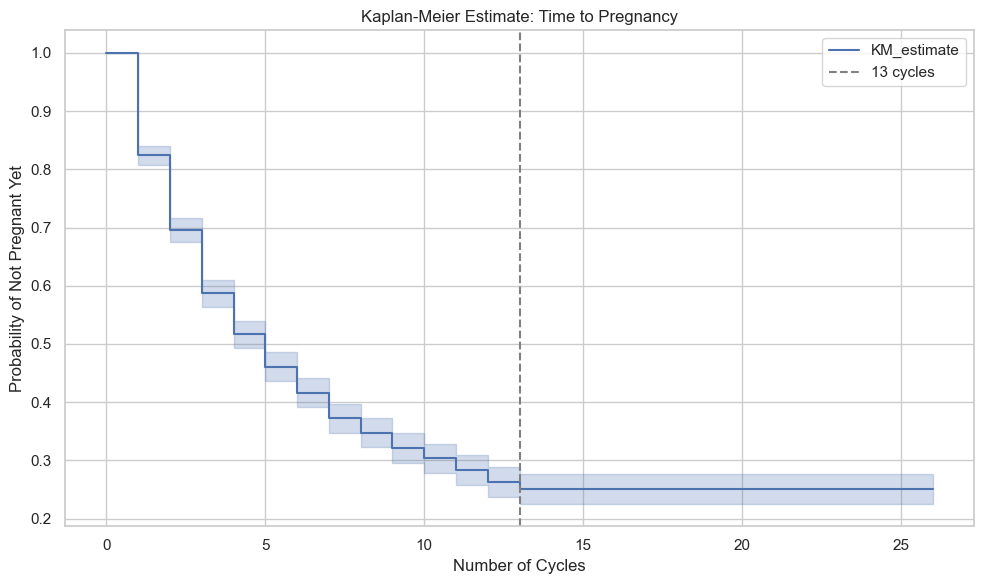

Chance of pregnancy within 13 cycles: 74.9%


In [10]:

# Prepare survival data
df['event'] = df['outcome'] == 'pregnant'
df['duration'] = df['n_cycles_trying']

# Fit Kaplan-Meier model
kmf = KaplanMeierFitter()
kmf.fit(durations=df['duration'], event_observed=df['event'])

# Plot
plt.figure(figsize=(10, 6))
kmf.plot_survival_function()
plt.axvline(x=13, color='gray', linestyle='--', label='13 cycles')
plt.title("Kaplan-Meier Estimate: Time to Pregnancy")
plt.xlabel("Number of Cycles")
plt.ylabel("Probability of Not Pregnant Yet")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('../results/Kaplan_meier_13.png')
plt.show()

# Print the chance of pregnancy within 13 cycles
print("Chance of pregnancy within 13 cycles: {:.1f}%".format((1 - kmf.predict(13)) * 100))


## 2- How long does it usually take to get pregnant?

### Estimate cumulative pregnant and find which cycle corresponds to when its 50% of people are pregnant

In [11]:
preg_table["Cumulative Pregnant"] = preg_table["Pregnant"].cumsum()
preg_table

,n_cycle,Remaining,Pregnant,Dropouts,Success Rate,Failure Rate,Cumulative Pregnant
0,1,1995,350,170,0.175,0.825,350
1,2,1475,229,115,0.155,0.845,579
2,3,1131,178,88,0.157,0.843,757
3,4,865,104,68,0.120,0.880,861
4,5,693,74,40,0.107,0.893,935
5,6,579,56,50,0.097,0.903,991
6,7,473,50,28,0.106,0.894,1041
7,8,395,27,33,0.068,0.932,1068
8,9,335,25,24,0.075,0.925,1093
9,10,286,16,25,0.056,0.944,1109


In [12]:
last_below_half = preg_table.loc[preg_table["Cumulative Pregnant"] < len(df)/2].index[-1]
last_below_half

np.int64(5)

### Kaplan-Meier Survival Analysis
Probability of not getting pregnant as cycles go on
Among all users, what is the cycle number at which 50% have gotten pregnant?

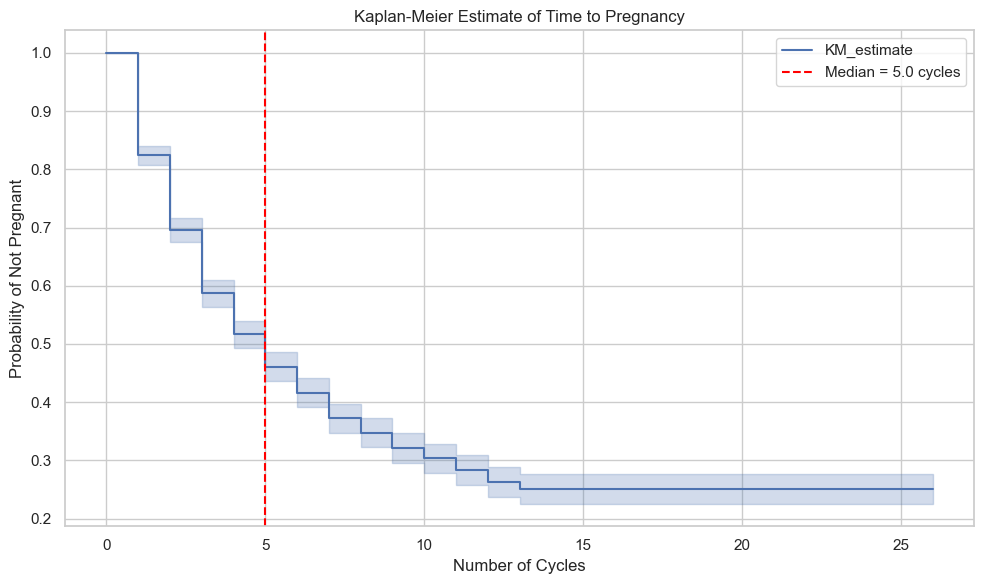

Median time to pregnancy: 5.0


In [11]:
# Initialize the Kaplan-Meier fitter
kmf = KaplanMeierFitter()

# Fit the model
durations = df['n_cycles_trying']
events = df['outcome'] == 'pregnant'
kmf.fit(durations, event_observed=events)
median_time = kmf.median_survival_time_

# Plot the survival function
plt.figure(figsize=(10, 6))
kmf.plot()
plt.axvline(median_time, color='red', linestyle='--', label=f'Median = {median_time:.1f} cycles')
plt.title('Kaplan-Meier Estimate of Time to Pregnancy')
plt.xlabel('Number of Cycles')
plt.ylabel('Probability of Not Pregnant')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('../results/Kaplan_meier_all.png')
plt.show()

print("Median time to pregnancy:", median_time)
#It usually takes around 5–6 cycles to get pregnant, accounting for those who didn’t conceive.

## 3- What factors impact the time it takes to get pregnant?
Model the factors affecting time to pregnancy

### Linear regression model


In [13]:
# Add categorical variables for modeling and clean data
df['pregnant'] = df['outcome'] == 'pregnant'

# Filter only pregnant users
pregnant_df = df[df['pregnant']].copy()

# Select and clean relevant columns
model_cols = [
    'n_cycles_trying', 'age', 'bmi', 'dedication', 'average_cycle_length',
    'cycle_length_std', 'intercourse_frequency',
    'education', 'sleeping_pattern', 'regular_cycle', 'been_pregnant_before'
]

# Drop rows with missing values
df_lin_mod = pregnant_df[model_cols].dropna().copy()

# One-hot encode categorical variables
df_lin_mod = pd.get_dummies(df_lin_mod, columns=[
    'education', 'sleeping_pattern', 'regular_cycle', 'been_pregnant_before'
], drop_first=True)
bool_cols = df_lin_mod.select_dtypes(include='bool').columns
df_lin_mod[bool_cols] = df_lin_mod[bool_cols].astype(int)
# Confirm all are numeric
assert df_lin_mod.dtypes.apply(lambda x: np.issubdtype(x, np.number)).all()


In [ ]:
# Train a linear regression model
y = df_lin_mod["n_cycles_trying"]
X = df_lin_mod.drop(columns="n_cycles_trying")

# scale input features
scaler = StandardScaler()
X_scaled_arr = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled_arr, columns=X.columns, index=X.index)

# add the intercept
X_scaled = sm.add_constant(X_scaled)

# fit and print summary
ols_std = sm.OLS(y, X_scaled).fit()
print(ols_std.summary())

                            OLS Regression Results                            
Dep. Variable:        n_cycles_trying   R-squared:                       0.102
Model:                            OLS   Adj. R-squared:                  0.080
Method:                 Least Squares   F-statistic:                     4.683
Date:                Thu, 12 Jun 2025   Prob (F-statistic):           6.52e-10
Time:                        23:44:18   Log-Likelihood:                -1797.4
No. Observations:                 759   AIC:                             3633.
Df Residuals:                     740   BIC:                             3721.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

In [ ]:
# Convert the summary table to a DataFrame
table_df = pd.DataFrame(ols_std.summary().tables[1].data)
table_df = table_df[table_df[0] != 'const']
table_df.columns = table_df.iloc[0]
table_df = table_df[1:]

# Filter rows where P>|t| < 0.05
filtered_table = table_df[table_df['P>|t|'].astype(float) < 0.05]
filtered_table


,,coef,std err,t,P>|t|,[0.025,0.975]
2,age,0.2700,0.108,2.508,0.012,0.059,0.481
4,dedication,-0.4675,0.102,-4.581,0.000,-0.668,-0.267
5,average_cycle_length,-0.5307,0.181,-2.931,0.003,-0.886,-0.175
6,cycle_length_std,0.4081,0.198,2.059,0.040,0.019,0.797
7,intercourse_frequency,-0.3298,0.102,-3.232,0.001,-0.530,-0.129
18,"been_pregnant_before_Yes, once",-0.2636,0.101,-2.603,0.009,-0.462,-0.065
19,"been_pregnant_before_Yes, twice",-0.3270,0.099,-3.291,0.001,-0.522,-0.132


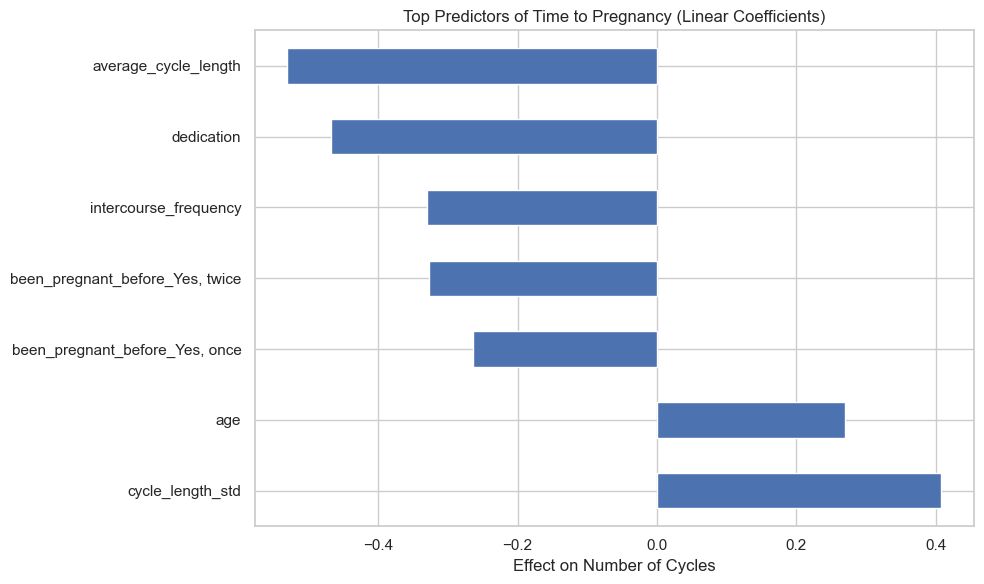

In [ ]:
# Extract coefficients and plot the top 10 predictors
coef_series = ols_std.params.drop('const')  # exclude intercept
top_features = filtered_table.iloc[:, 0].to_list()

plt.figure(figsize=(10, 6))
coef_series[top_features].sort_values(ascending=False).plot(kind='barh')
plt.title("Top Predictors of Time to Pregnancy (Linear Coefficients)")
plt.xlabel("Effect on Number of Cycles")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Save the summary table to a CSV file
table0 = pd.DataFrame(ols_std.summary().tables[1].data)
table0.to_csv('../results/norm_linear.csv', index=False, header=False)

### Cox Proportional Hazards Model



In [ ]:

# Select and clean relevant columns
cox_cols = [
    'n_cycles_trying', 'pregnant', 'age', 'bmi', 'dedication',
    'average_cycle_length', 'cycle_length_std', 'intercourse_frequency',
    'education', 'sleeping_pattern', 'regular_cycle', 'been_pregnant_before'
]

# Drop rows with missing values
cox_df = df[cox_cols].dropna().copy()

# One-hot encode categorical variables and convert bools to int
cox_df = pd.get_dummies(cox_df, columns=[
    'education', 'sleeping_pattern', 'regular_cycle', 'been_pregnant_before'
], drop_first=True)

bool_cols = cox_df.select_dtypes(include='bool').columns
cox_df[bool_cols] = cox_df[bool_cols].astype(int)

X = cox_df.drop(columns=["n_cycles_trying", "pregnant"])      # predictors
X_scaled = pd.DataFrame(StandardScaler().fit_transform(X), columns=X.columns, index=X.index)

norm_cox_df = pd.concat([cox_df[["n_cycles_trying", "pregnant"]], X_scaled], axis=1)

# Fit Cox model
cph = CoxPHFitter()
cph.fit(norm_cox_df, duration_col='n_cycles_trying', event_col='pregnant')

# Display summary
cph_summary = cph.summary
cph_summary.sort_values(by='exp(coef)', ascending=False, inplace=True)
cph_summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
dedication,0.448196,1.565485,0.046650,0.356763,0.539628,1.428698,1.715369,0.0,9.607616,7.424794e-22,70.190067
intercourse_frequency,0.284754,1.329435,0.038633,0.209035,0.360473,1.232488,1.434007,0.0,7.370795,1.696134e-13,42.422815
average_cycle_length,0.169538,1.184757,0.068851,0.034591,0.304484,1.035196,1.355925,0.0,2.462368,1.380230e-02,6.178948
"been_pregnant_before_Yes, once",0.134703,1.144197,0.038489,0.059266,0.210140,1.061058,1.233850,0.0,3.499798,4.656115e-04,11.068586
"been_pregnant_before_Yes, twice",0.121314,1.128979,0.038234,0.046376,0.196251,1.047468,1.216833,0.0,3.172918,1.509154e-03,9.372045
been_pregnant_before_Yes 3 times or more,0.064175,1.066279,0.041953,-0.018052,0.146402,0.982110,1.157662,0.0,1.529667,1.260991e-01,2.987370
education_PhD,0.059595,1.061406,0.150110,-0.234615,0.353804,0.790875,1.424476,0.0,0.397007,6.913623e-01,0.532486
sleeping_pattern_Shift worker,0.036069,1.036728,0.062161,-0.085763,0.157902,0.917812,1.171051,0.0,0.580260,5.617394e-01,0.832027
education_University,0.033248,1.033807,0.211249,-0.380793,0.447289,0.683319,1.564066,0.0,0.157388,8.749391e-01,0.192745


In [ ]:
# Save the summary to a CSV file
cph_summary.to_csv('../results/cph_summary2.csv')

In [ ]:
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 1240 total observations, 481 right-censored observations>
             duration col = 'n_cycles_trying'
                event col = 'pregnant'
      baseline estimation = breslow
   number of observations = 1240
number of events observed = 759
   partial log-likelihood = -4766.42
         time fit was run = 2025-06-11 20:26:21 UTC

---
                                                 coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                                        
age                                             -0.05      0.95      0.01           -0.07           -0.03                0.93                0.97
bmi                                             -0.00      1.00      0.01           -0.02            0.01                0.98                1.01
dedication                                       1.41      4.10      0.15            1.12            1.70                3.07                5.46
average_cycle_length                             0.03      1.03      0.01            0.01            0.05                1.01                1.05
cycle_length_std                                -0.02      0.98      0.01           -0.05            0.00                0.96                1.00
intercourse_frequency                            2.65     14.08      0.36            1.94            3.35                6.97               28.46
education_High school                           -0.02      0.98      0.46           -0.92            0.89                0.40                2.45
education_PhD                                    0.18      1.20      0.46           -0.72            1.09                0.48                2.98
education_Trade/technical/vocational training   -0.06      0.95      0.47           -0.97            0.86                0.38                2.36
education_University                             0.07      1.07      0.45           -0.81            0.96                0.44                2.60
sleeping_pattern_Several times during the night -0.03      0.97      0.20           -0.42            0.36                0.66                1.43
sleeping_pattern_Shift worker                    0.12      1.13      0.21           -0.29            0.54                0.75                1.71
sleeping_pattern_Wake same every day            -0.09      0.92      0.20           -0.47            0.30                0.62                1.35
sleeping_pattern_Wake same every workday        -0.03      0.97      0.18           -0.39            0.32                0.68                1.38
regular_cycle_True                               0.08      1.08      0.12           -0.15            0.30                0.86                1.36
been_pregnant_before_Yes 3 times or more         0.37      1.45      0.24           -0.10            0.85                0.90                2.34
been_pregnant_before_Yes, once                   0.36      1.43      0.10            0.16            0.56                1.17                1.75
been_pregnant_before_Yes, twice                  0.50      1.65      0.16            0.19            0.81                1.21                2.24

                                                 cmp to     z      p  -log2(p)
covariate                                                                     
age                                                0.00 -4.45 <0.005     16.82
bmi                                                0.00 -0.30   0.76      0.39
dedication                                         0.00  9.61 <0.005     70.19
average_cycle_length                               0.00  2.46   0.01      6.18
cycle_length_std                                   0.00 -1.82   0.07      3.87
intercourse_frequency                              0.00  7.37 <0.005     42.42
education_High school                              0.00 -0.03   0.97     

### Plot comparison of linear and Cox model

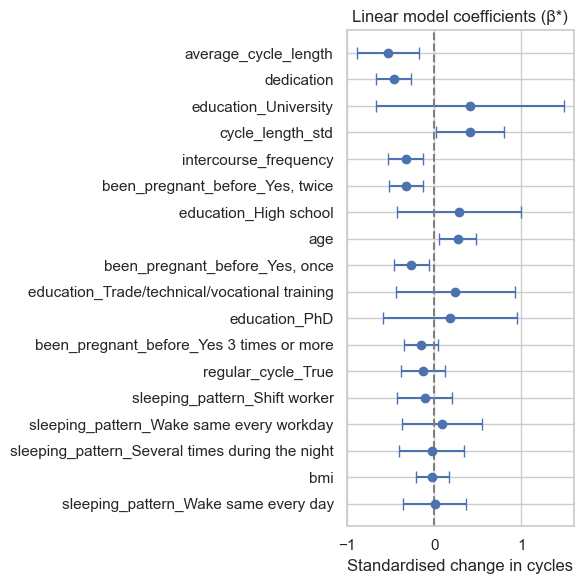

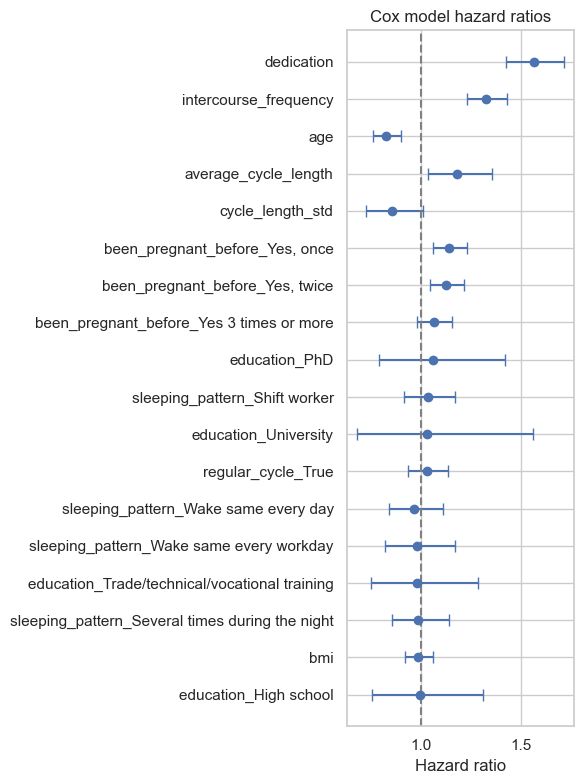

In [ ]:
lin1 = pd.read_csv('../results//norm_linear.csv', index_col=0)

# Identify coefficient and CI columns
lin1 = lin1.drop(index='const', errors='ignore')

beta   = lin1['coef'] 
ci_lower = lin1['[0.025']
ci_upper = lin1['0.975]']


order  = beta.abs().sort_values(ascending=False).index


plt.figure(figsize=(6, 6))
y = np.arange(len(order))
plt.errorbar(beta.loc[order], y,
             xerr=[beta.loc[order]-ci_lower.loc[order],
                   ci_upper.loc[order]-beta.loc[order]],
             fmt='o', capsize=4)
plt.axvline(0, ls='--', c='grey')
plt.yticks(y, order)
plt.gca().invert_yaxis()
plt.xlabel('Standardised change in cycles')
plt.title('Linear model coefficients (β*)')
plt.tight_layout()
plt.savefig('../results/linear_model_coefficients.png')
# plt.close()
# Cox model plotting

cox = pd.read_csv('../results/cph_summary2.csv', index_col=0)

# Extract hazard ratios and CIs
hr      = np.exp(cox['coef'])          # convert if needed
ci_lo   = np.exp(cox['coef lower 95%'])
ci_hi   = np.exp(cox['coef upper 95%'])
impact  = cox['coef'].abs()            # |log-HR|
order   = impact.sort_values(ascending=False).index



impact_cox = (hr - 1).abs()
order_cox = impact_cox.sort_values(ascending=False).index


plt.figure(figsize=(6, 8))
y = np.arange(len(order))
plt.errorbar(hr.loc[order], y,
             xerr=[hr.loc[order]-ci_lo.loc[order],
                   ci_hi.loc[order]-hr.loc[order]],
             fmt='o', capsize=4)
# plt.xscale('log')
plt.axvline(1, ls='--', c='grey')
plt.yticks(y, order)
plt.gca().invert_yaxis()
plt.xlabel('Hazard ratio')
plt.title('Cox model hazard ratios')
plt.tight_layout()
plt.savefig('../results/cox_model_coefficients.png')
# plt.close()
